# Introdução

## Objetivo

O objetivo deste trabalho é aplicar a teoria de **Estatística, Máxima Verossimilhança e Inferência Bayesiana** a um conjunto de dados real. É essencial que seja realizada uma análise e interpretação dos resultados encontrados em todas as etapas. O dataset a ser analisado contém medições de parâmetros de conexões da Internet.

As análises incluem:
- Calcular estatísticas descritivas e elaborar gráficos exploratórios.
- Ajustar modelos paramétricos utilizando a Máxima Verossimilhança (MLE).
- Realizar inferência bayesiana com priors conjugadas para obter as posteriors e
previsões.
- Comparar as estimativas MLE vs Bayes.

## Bibliotecas utilizadas

In [59]:
#%pip install matplotlib
#%pip install pandas
#%pip install plotly
#%pip install nbformat
#%pip install scipy
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
from scipy.stats import gaussian_kde
import seaborn as sns


## Dataset utilizado

O dataset M-Lab NDT (Medições de desempenho de rede Internet) possui dados de desempenho de rede (throughput, RTT, perda de pacotes) com acesso público via BigQuery. Para este projeto, será usado um subconjunto:
* O conjunto de dados será fornecido no arquivo datasets/ndt_tests_tratado.csv
* As variáveis incluem: throughput de download e upload (em bits por segundo), RTT de download e upload (em segundos) e fração de perda de pacotes (percentual)
* O dataset possui 13 clientes e 7 servidores
A primeira coluna contém a data e a hora da coleta dos dados

In [14]:
path = './datasets/ndt_tests_corrigido.csv'
df = pd.read_csv(path)
df.head(2)

timestamp  download_throughput_bps  rtt_download_sec  \
0  2025-08-09 15:28:02.000 +0000             8.223657e+07          0.231862   
1  2025-08-09 15:30:11.000 +0000             9.027315e+08          0.012000   

   upload_throughput_bps  rtt_upload_sec  packet_loss_percent    client  \
0           6.973217e+07        0.247727             0.000000  client12   
1           8.521780e+08        0.005423             0.008226  client01   

     server  
0  server06  
1  server07

## Estatísticas descritivas e gráficos exploratórios

### Entendendo o dataset

Primeiro passo: identificar as colunas e seus tipos.

In [15]:
display(df.dtypes)

timestamp                   object
download_throughput_bps    float64
rtt_download_sec           float64
upload_throughput_bps      float64
rtt_upload_sec             float64
packet_loss_percent        float64
client                      object
server                      object
dtype: object

In [16]:
# salvando as colunas em variáveis para facilitar futuras
# mudanças se necessário
server_col = 'server'
time_col = 'timestamp'
client_col = 'client'
down_tpt_col = 'download_throughput_bps'
down_rtt_col = 'rtt_download_sec'
up_tpt_col = 'upload_throughput_bps'
up_rtt_col = 'rtt_upload_sec'
packet_col = 'packet_loss_percent'
dow_col = 'day_of_week'

metrics=[down_tpt_col, down_rtt_col, up_tpt_col, up_rtt_col, packet_col]

Verificando se há dados nulos

In [17]:
df.isna().sum()

timestamp                  0
download_throughput_bps    0
rtt_download_sec           0
upload_throughput_bps      0
rtt_upload_sec             0
packet_loss_percent        0
client                     0
server                     0
dtype: int64

Verificando estatísticas de cada coluna:

In [18]:
for c in df.columns:
	display(c)
	display(df[c].describe())

'timestamp'

count                              7087
unique                             7076
top       2025-08-17 11:55:59.000 +0000
freq                                  2
Name: timestamp, dtype: object

'download_throughput_bps'

count    7.087000e+03
mean     5.062996e+08
std      3.352129e+08
min     -1.000000e+00
25%      1.642170e+08
50%      5.960927e+08
75%      8.489080e+08
max      9.332671e+08
Name: download_throughput_bps, dtype: float64

'rtt_download_sec'

count    7087.000000
mean        0.048447
std         0.067859
min        -0.001000
25%         0.008000
50%         0.011549
75%         0.115000
max         0.398051
Name: rtt_download_sec, dtype: float64

'upload_throughput_bps'

count    7.087000e+03
mean     3.781607e+08
std      3.014096e+08
min     -1.000000e+00
25%      9.733497e+07
50%      2.979242e+08
75%      6.701694e+08
max      9.214500e+08
Name: upload_throughput_bps, dtype: float64

'rtt_upload_sec'

count    7087.000000
mean        0.037194
std         0.063537
min        -1.000000
25%         0.004918
50%         0.010858
75%         0.017723
max         0.360227
Name: rtt_upload_sec, dtype: float64

'packet_loss_percent'

count    7087.000000
mean        1.899137
std         3.449941
min        -1.000000
25%         0.001484
50%         0.189771
75%         2.050781
max        22.389090
Name: packet_loss_percent, dtype: float64

'client'

count         7087
unique          13
top       client10
freq           664
Name: client, dtype: object

'server'

count         7087
unique           7
top       server07
freq          3746
Name: server, dtype: object

### Tratando os dados

#### Formatando timestamp

Após identificar a coluna timestamp, formatando-a:
- convertendo para tipo datetime
- removendo milisegundos
- ordenando por timestamp

In [19]:
df_formated  = df.copy()
df_formated[time_col] = pd.to_datetime(df_formated[time_col])
df_formated[time_col] = df_formated[time_col].dt.floor('s')
df_formated = df_formated.sort_values(by=[time_col, server_col, client_col])

df_formated.head(2)

timestamp  download_throughput_bps  rtt_download_sec  \
335 2025-08-01 00:02:31+00:00             1.479141e+07          0.398051   
337 2025-08-01 00:57:47+00:00             2.506106e+07          0.339698   

     upload_throughput_bps  rtt_upload_sec  packet_loss_percent    client  \
335           2.468495e+06        0.342112             9.224381  client10   
337           1.577260e+08        0.011713             2.720267  client12   

       server  
335  server06  
337  server07

#### Remoção de valores negativos

Com base nas estatísticas anteriores, foi possível observar que algumas métricas estão com valores negativos, o que não é condizente com a forma como são calculadas. Portanto, esses valores foram considerados outliers de erro e, por isso, foram removidos.

In [ ]:

def remove_negative_outlier(df, metric):
    """
		@description	encontra e remove os valores negativos
						da métrica selecionada e retorna um dataset
                        limpo
	    @param	df	dataset
        @param	metric	métrica a ser limpa
    """
    df_no_out = df.copy()
    df_no_out = df_no_out[df_no_out[metric] >= 0]
    return df_no_out

In [21]:
df_no_out = df_formated.copy()

for metric in metrics:
	df_no_out = remove_negative_outlier(df_no_out, metric)

### Análise do Boxplot

Após a remoção, os gráficos boxplot foram plotados, para mostrar a mediana, variância e outliers dos dados. No geral, pode ser observado que quanto menor a variância dos dados, maior a quantidade de outliers.

In [ ]:
def plot_outliers(x_col, df, metrics,  n_cols=2):
	"""
		@description	plota outliers de cada métrica para cada label
		@param	x_col	coluna selecionada para agrupamento (client ou server)
		@param	df	dataset
		@param	metric_col	nome da coluna da métrica selecionada
	"""
	n_rows = (len(metrics) + n_cols - 1) // n_cols  

	fig = make_subplots(
		rows=n_rows,
		cols=n_cols,
		subplot_titles=[m.replace('_', ' ').title() for m in metrics]
	)

	for i, metric_col in enumerate(metrics):
		row = i // n_cols + 1
		col = i % n_cols + 1

		fig.add_trace(
			go.Box(
				x=df[x_col],
				y=df[metric_col],
				boxpoints='all',
				jitter=0.3,
				marker=dict(size=3),
				name=metric_col.replace('_', ' ').title()
			),
			row=row,
			col=col
		)

	fig.update_layout(
		height=200 * n_rows,
		showlegend=False,
		title_text="Outlier Distribution Across Servers",
		template='plotly_white'
	)

	fig.show()

def plot_outliers_by_label(x_col, label_col, df, metric_col):
	"""
		@description	plota outliers de cada métrica para cada label
		@param	x_col	coluna selecionada para agrupamento (client ou server)
		@param	label_col coluna selecionada para definir as classes (client ou server)
		@param	df	dataset
		@param	metric_col	nome da coluna da métrica selecionada
	"""
	fig = px.box(
		df,
		x=x_col,
		y=metric_col,
		color=label_col,
		points='all', 
		title=f"{metric_col.replace('_', ' ').title()} Outlies Across Servers",
		template='plotly_white'
	)

	fig.show()


In [22]:
plot_outliers(server_col, df_no_out, metrics)

Abaixo, está análise do boxplot para clientes. Podemos ressaltar:
- a baixa variância do client13 em todas as métricas, o que mostra consistência.
- O client08 parece ter enviado e recebido uma quantidade grande de dados acima do seu padrão usual e isso parece ter influenciado no seu RTT e no sua alta perda de pacotes. 
- O client05 tem grande variância e média baixa de throughput (up e down) e média alta de pera de pacotes

In [53]:
plot_outliers(client_col, df_no_out, metrics)

Cruzando os dois rótulos, abaixo, temos clientes por servidor em cada métrica. Podemos destacar:
- o comportamento do client05, o server no qual pior performou foi o server05, cujo o thrpughput foi baixo, o RTT e a perda de pacotes foi alta.
- o client13 mantém performance similar em todos os servers
- os clients 10, 11, 08 e 05 costumam ter maior variância no throughput
- os servers 04, 05 e 06 costumam ter throughput baixo para a maioria dos clientes
- os servers 01, 02 e 03 possui os RTTs mais baixos para todos os clientes
- os servers 01, 02, 03 e 07 possuem os maiores throuputs


In [24]:
for metric in metrics:
	plot_outliers_by_label(server_col, client_col, df_no_out, metric)

Baseado nas análises anteriores, os clientes que mais diminuem a performance dos servers são os clientes 05, 08, 10, 11 e 13. Ao removê-los do dataset, podemos ver como a variância e a amplitude das métricas diminuem, e as médias de perda caem. As métricas de RTT se tornam basicamente a média.

In [25]:
df_test = df_no_out[~df_no_out[client_col].isin(['client05', 'client08', 'client10', 'client11', 'client13'])]

plot_outliers(server_col, df_test, metrics)

### Análise das proporções

In [26]:
def plot_proportion_metric(df, first_group, second_group, metrics, n_cols=2):
    n_rows = (len(metrics) + n_cols - 1) // n_cols
    fig = make_subplots(
        rows=n_rows, cols=n_cols,
        subplot_titles=[f"Proportion of {m} per {second_group} for Each {first_group}" for m in metrics],
        horizontal_spacing=0.08,
        vertical_spacing=0.15
    )

    for i, metric in enumerate(metrics):
        new_col = f"{metric}_prop"

        df_prop = (
            df.groupby([first_group, second_group], as_index=False)[metric]
            .sum()
        )
        df_prop[new_col] = (
            df_prop[metric] /
            df_prop.groupby(first_group)[metric].transform('sum')
        ).round(4)

        bar_fig = px.bar(
            df_prop,
            x=first_group,
            y=new_col,
            color=second_group,
            text_auto='.1%',
        )

        row = i // n_cols + 1
        col = i % n_cols + 1

        for trace in bar_fig.data:
            fig.add_trace(trace, row=row, col=col)

    fig.update_layout(
        template='plotly_white',
        barmode='stack',
        height=400 * n_rows, 
        width=1600,          
        showlegend=True,
        title_text="Proportional Metrics Grid",
        title_x=0.5
    )

    fig.update_yaxes(tickformat='.0%')
    fig.show()


Aqui, o foc foi analisar a contribuição de cada cliente nos valores de cada server:
- Podemos notar que o client13 é o cliente com mais perdas na maioria dos servers
- O client05 representa ao taxa de perdas em todos os servers
- O client12 é o com menos perdas em todos os servers
- O client08 tem uma perda de pacote significativa em todos os servers, apesar de ter pouca expressividade nas demais métricas

No geral, os servers tem uma experiência parecida com cada cliente, exceto para os clientes 11, 12 e 13.

In [27]:
plot_proportion_metric(df_no_out, server_col, client_col, metrics)

Analisando a contribuição dos servers nas métricas dos clientes, podemos notar que, no geral, a experiência dos clientes com os servers é bem similar com algumas diferenças para os clientes 11, 12, 13.

In [28]:
plot_proportion_metric(df_no_out, client_col, server_col, metrics)

### Análise das distribuições

Como os servers não parecem influenciar muito na performance, abaixo analisamos as medidas de centralidade dos clientes com perfomance mais destoantes: 05, 08, 10, 11 e 13. Os clientes com a pior performance parecem ser o 05 e o 08, já que possuem menor mediana de troughput, maior mediana de perda de pacotes. Para essa análise foram escolhidos os percentis 95 e 5, pois expressam casos extremos (pior caso e melhor caso). Com base nos percentis, foi possível ver que para ambos os clientes, a maior parte do throughput (95%) se manteve acima da mediana e a menor parte (5%), abaixo.

In [29]:
# Define as estatísticas descritivas a calcular
agg_funcs = [
    'mean',
    'median',
    'var',
    'std',
    ('quantile_0.05', lambda x: x.quantile(0.05)),
    ('quantile_0.95', lambda x: x.quantile(0.95))
]

# 1. Calcular estatísticas descritivas agrupadas por 'client'
problematic_clients = df_no_out[df_no_out[client_col].isin(['client05', 'client08', 'client10', 'client11', 'client13'])]
stats_client = problematic_clients.groupby(client_col)[metrics].agg(agg_funcs)

# 2. Calcular estatísticas descritivas agrupadas por 'server'
stats_server = df_no_out.groupby(server_col)[metrics].agg(agg_funcs)

# Achata as colunas MultiIndex
stats_client.columns = [f'{col[0]}_{col[1]}' for col in stats_client.columns]
stats_server.columns = [f'{col[0]}_{col[1]}' for col in stats_server.columns]

stats_client = stats_client.sort_values(by='download_throughput_bps_median')
stats_server = stats_server.sort_values(by='download_throughput_bps_mean') 

print("Client Descriptive Statistics (Head):")
print(stats_client.head())

Client Descriptive Statistics (Head):
          download_throughput_bps_mean  download_throughput_bps_median  \
client                                                                   
client08                  2.338896e+08                    9.639645e+07   
client05                  3.095310e+08                    1.069629e+08   
client10                  2.317913e+08                    2.211362e+08   
client13                  5.939332e+08                    5.961439e+08   
client11                  5.046348e+08                    6.906440e+08   

          download_throughput_bps_var  download_throughput_bps_std  \
client                                                               
client08                 8.546441e+16                 2.923430e+08   
client05                 1.120610e+17                 3.347551e+08   
client10                 2.756848e+16                 1.660376e+08   
client13                 4.850877e+14                 2.202471e+07   
client11               

Abaixo, estão as medidas para servers, podemos ver que no geral, não há um server com performance muito expressiva. O server 04 é o com menor mediana de throughput, porém não é o com maior perda. O server 05 é o segundo menor throughput, e apesar de sua mediana de perda ser baixa, quando analisado o percentil 95, temos a maior perda.

In [30]:

print("Serveres Descriptive Statistics (Head):")
print(stats_server.head())

Serveres Descriptive Statistics (Head):
          download_throughput_bps_mean  download_throughput_bps_median  \
server                                                                   
server04                  1.969232e+08                    1.685083e+08   
server05                  2.012037e+08                    1.688241e+08   
server06                  2.056048e+08                    1.695963e+08   
server07                  5.855321e+08                    7.093078e+08   
server02                  6.366642e+08                    7.618315e+08   

          download_throughput_bps_var  download_throughput_bps_std  \
server                                                               
server04                 3.144230e+16                 1.773198e+08   
server05                 3.350480e+16                 1.830432e+08   
server06                 3.640356e+16                 1.907972e+08   
server07                 1.078581e+17                 3.284175e+08   
server02             

### Extração de padrões sazonais

Como é uma série temporal, extraindo dados temporais para ver se há tedências cíclicas/sazonais nos dados. Para isso, agregando dados por minuto, horas, dias, semanas, mês. O agrupamento foi feito pensando nas colunas client ou server.

In [34]:
min_col='minute'
hour_col='hour'
day_col='day'

def generate_temporal_datasets_for_label(label, df_formated):
	"""
		@description	Extrai do dataset aggregações temporais de minuto, hora, dia, 
						dia da semana, semana, mês. As metricas são agregadas usando
						media. A saida são 6 datasets para cada análise temporal.
		@param	label	campo usado para agrupar os dados temporais (client ou server)
		@param	df_formated	dataset
	"""

	# metrica a sere agregadas 
	agg_metric = { 
			down_tpt_col: 'mean', 
			down_rtt_col: 'mean',  
			up_tpt_col: 'mean', 
			up_rtt_col: 'mean',
			packet_col: 'mean'
		}
	
	def group(label, freq):
		return (df_formated
					.groupby([label, pd.Grouper(key=time_col, freq=freq)])
					.agg(agg_metric)
					.reset_index()
				)

	#df_min = group(label, 'min')
	#df_hour = group(label, 'h')
	#df_day = group(label, 'd')
	df_weekly = group(label, 'W')
	df_monthly = group(label, 'ME')

	## MINUTES
	df_formated[min_col] = df_formated[time_col].dt.minute
	df_min = (
		df_formated
		.groupby([label, min_col], sort=False)
		.agg(agg_metric)
		.reset_index()
	)
	df_min = df_min.sort_values([label, min_col])

	## HOUR
	df_formated[hour_col] = df_formated[time_col].dt.hour
	df_hour = (
		df_formated
		.groupby([label, hour_col], sort=False)
		.agg(agg_metric)
		.reset_index()
	)
	df_hour = df_hour.sort_values([label, hour_col])

	## DAY
	df_formated[day_col] = df_formated[time_col].dt.day
	df_day = (
		df_formated
		.groupby([label, day_col], sort=False)
		.agg(agg_metric)
		.reset_index()
	)
	df_day = df_day.sort_values([label, day_col])


	## DAY OF WEEK
	df_formated[dow_col] = df_formated[time_col].dt.day_name()
	df_dow = (
		df_formated
		.groupby([label, dow_col], sort=False)
		.agg(agg_metric)
		.reset_index()
	)
	weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
	df_dow[dow_col] = pd.Categorical(df_dow[dow_col], categories=weekday_order, ordered=True)
	df_dow = df_dow.sort_values([label, dow_col])

	return df_min, df_hour, df_day, df_weekly, df_monthly, df_dow


#### Análise mensal

In [35]:
def plot_metrics_for_month(df_plot, time_col, y_cols, label_col, title='Month'):
	"""
		@description	gera histograma para os dados mensais
		@param	df_plot	dataset com os dados já agrupados mensalmente
		@param	time_col	o nome da coluna de timestamp
		@param	y_cols	um array com todas as colunas de métricas que
						serão plotadas
		@param	label_col	nome da coluna que foi usada para agrupar
							os dados
		@param	title	nome do faixa temporal (e.g. Month)

	"""
	fig = px.histogram(
		df_plot,
		x=label_col,
		y=y_cols,
		nbins=30,
		barmode='overlay',
		title=f"Metrics Over {title}",
		labels={
				time_col: "Time",
				label_col: "Server"
			}
	)

	fig.update_layout(
		template='plotly_white',
		barmode='overlay'
	)
	fig.update_traces(opacity=0.6)
	fig.show()

def generate_month_plot_for_label(label_col, df):
	"""
		@description	gera o plot mensal para a coluna escolhida para 
						agrupamento (client ou server)
		@param	label_col	nome da coluna de agrupamento (client ou server)
	"""
	y_col = [down_tpt_col, down_rtt_col, up_rtt_col, up_tpt_col, packet_col]
	_, _, _, _, df_monthly, _ = generate_temporal_datasets_for_label(label_col, df)
	plot_metrics_for_month(df_monthly, time_col,  y_col, label_col)


In [36]:
generate_month_plot_for_label(server_col, df_no_out)

In [37]:
generate_month_plot_for_label(client_col, selected_clients.copy())

In [38]:
import math
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_metrics_over_time_grid(df_plot, time_col, y_cols, label_col, title, cols=2):
    rows = math.ceil(len(y_cols) / cols)
    
    # Create subplot grid
    fig = make_subplots(
        rows=rows,
        cols=cols,
        subplot_titles=[y.replace('_', ' ').title() for y in y_cols]
    )
    
    # Color palette
    servers = df_plot[label_col].unique()
    colors = px.colors.qualitative.Plotly
    color_map = {s: colors[i % len(colors)] for i, s in enumerate(servers)}
    
    # Add traces
    for i, y in enumerate(y_cols):
        row = (i // cols) + 1
        col = (i % cols) + 1
        for j, server in enumerate(servers):
            df_s = df_plot[df_plot[label_col] == server]
            fig.add_trace(
                go.Scatter(
                    x=df_s[time_col],
                    y=df_s[y],
                    mode='lines+markers',
                    name=server if i == 0 else None,  # show legend only once
                    showlegend=(i==0),  # only show legend for the first metric
                    marker=dict(size=5),
                    line=dict(color=color_map[server])
                ),
                row=row,
                col=col
            )
    
    # Update layout
    fig.update_layout(
        height=300*rows,
        title_text=f"Server Metrics Over {title}",
        template='plotly_white',
        legend_title_text='Server'
    )
    
    fig.show()



In [39]:
def plot_metrics_over_time(df_plot, time_col, y_cols, label_col, title): 
	for y in y_cols: 
		fig = px.line( 
			df_plot, 
			x=time_col, 
			y=y, 
			color=label_col, 
			markers=True, 
			title=f"{y.replace('_', ' ').title()} Over {title}", 
			labels={ time_col: "Time", y: y.replace('_', ' ').title(), label_col: "Server" } 
		) 
		
		fig.update_layout( legend_title_text='Server', template='plotly_white', yaxis_tickformat=',' ) 
		fig.show()

In [40]:
def plot_metrics_over_time2(df_plot, time_col, y_cols, label_col, title): 
	for y in y_cols: 
		fig = px.line( 
			df_plot, 
			x=time_col, 
			y=y, 
			color=[label_col, 'server'], 
			markers=True, 
			title=f"{y.replace('_', ' ').title()} Over {title}", 
			labels={ time_col: "Time", y: y.replace('_', ' ').title(), label_col: "Server" } 
		) 
		
		fig.update_layout( legend_title_text='Server', template='plotly_white', yaxis_tickformat=',' ) 
		fig.show()


In [41]:
def generate_plot_for_label2(label_col, time_col, df):
	y_col = [down_tpt_col, down_rtt_col, up_rtt_col, up_tpt_col, packet_col]
	df_min, df_hour, df_day, df_weekly, _, df_dow = generate_temporal_datasets_for_label(label_col, df)

	time_freq = [df_min, df_hour, df_day, df_dow, df_weekly]
	x_col = [min_col, hour_col, day_col, dow_col, time_col]
	titles = ['Minutes','Hour', 'Day', 'Day of Week', 'Weekly']

	for time_df, time_col, title in zip(time_freq, x_col, titles):
		plot_metrics_over_time2(time_df, time_col,  y_col, label_col, title)

In [42]:
def generate_plot_for_label(label_col, time_col, df):
	y_col = [down_tpt_col, down_rtt_col, up_rtt_col, up_tpt_col, packet_col]
	df_min, df_hour, df_day, df_weekly, _, df_dow = generate_temporal_datasets_for_label(label_col, df)

	time_freq = [df_min, df_hour, df_day, df_dow, df_weekly]
	x_col = [min_col, hour_col, day_col, dow_col, time_col]
	titles = ['Minutes','Hour', 'Day', 'Day of Week', 'Weekly']

	for time_df, time_col, title in zip(time_freq, x_col, titles):
		plot_metrics_over_time(time_df, time_col,  y_col, label_col, title)


In [43]:
generate_plot_for_label(server_col, time_col, df_no_out)

In [44]:
generate_plot_for_label(client_col, time_col, selected_clients.copy())

## Escolha do modelo paramétrico

In [47]:
selected_clients = problematic_clients[problematic_clients[client_col].isin(['client05', 'client08'])]

In [84]:
def compare_metric_distribution(df, metric_col, label_col='server', overlay=True):
    """
		@description	Plota um gráfico para todas as 5 métricas comparando de acordo
						com a label especificada (client ou server)
    """
    fig = px.histogram(
        df,
        x=metric_col,
        color=label_col,
        nbins=30,
        barmode='overlay' if overlay else 'group',
        opacity=0.6,
        template='plotly_white',
        title=f"Distribution of {metric_col.replace('_', ' ').title()} Across Servers",
        labels={metric_col: metric_col.replace('_', ' ').title(), label_col: 'Server'}
    )

    fig.update_layout(legend_title_text=label_col)
    fig.show()

def compare_KDE(df, label_col, metric_col):
	kde_data = []
	for label, group in df.groupby(label_col):
		kde = gaussian_kde(group[metric_col].dropna())
		xs = np.linspace(group[metric_col].min(), group[metric_col].max(), 200)
		ys = kde(xs)
		kde_data.append(pd.DataFrame({metric_col: xs, 'density': ys, label_col: label}))

	kde_df = pd.concat(kde_data, ignore_index=True)

	fig = px.line(
		kde_df,
		x=metric_col,
		y='density',
		color=label_col,
		title=f"KDE Distribution of {metric_col.replace('_', ' ').title()} Across Servers",
		labels={
			metric_col: metric_col.replace('_', ' ').title(),
			'density': 'Density',
			label_col: 'Server'
		},
		template='plotly_white'
	)
	fig.update_traces(line=dict(width=2))
	fig.update_layout(height=400, width=500, )
	fig.show()

def compare_metric_distribution_with_kde(df, metric_col, label_col='server', nbins=30):
    """
    """

    # Create base figure
    fig = go.Figure()

    # Generate histogram + KDE for each group
    for label, group in df.groupby(label_col):
        # Histogram trace
        fig.add_trace(go.Histogram(
            x=group[metric_col],
            name=f"{label} (hist)",
            opacity=0.5,
            nbinsx=nbins,
            histnorm='probability density'  # normalize to match KDE scale
        ))

        # KDE curve
        metric_data = group[metric_col].dropna()
        if len(metric_data) > 1:  # avoid errors for small samples
            kde = gaussian_kde(metric_data)
            xs = np.linspace(metric_data.min(), metric_data.max(), 200)
            ys = kde(xs)
            fig.add_trace(go.Scatter(
                x=xs,
                y=ys,
                mode='lines',
                name=f"{label} (KDE)",
                line=dict(width=2)
            ))

    # Layout styling
    fig.update_layout(
        title=f"Histogram + KDE of {metric_col.replace('_', ' ').title()} Across {label_col.title()}s",
        xaxis_title=metric_col.replace('_', ' ').title(),
        yaxis_title='Density',
        barmode='overlay',
        template='plotly_white',
        legend_title_text=label_col.title(),
        height=500,
        width=900
    )

    fig.show()
    
def plot_using_matplot(df, metrics, label_col, client_id):	
	tpt_metrics=[down_tpt_col, up_tpt_col]

	df_client = df[df[label_col] == client_id].copy()

	def get_title(metric, id):
		return f'{metric} - {id}'

	# --- 1. Histogramas ---
	plt.figure(figsize=(18, 5))
	for i, var in enumerate(metrics):
		plt.subplot(1, 5, i + 1)
		sns.histplot(df_client[var], kde=True)
		plt.title(f'Histogram: {get_title(var, client_id)}')
		plt.xlabel(var)
		if var in tpt_metrics:
			plt.xscale('log')
			plt.xlabel('Throughput (bps) - Escala Log')

	plt.tight_layout()
	plt.savefig(f"./results/{client_id}_histograms.png")
	plt.show()

	# --- 2. Boxplots ---
	plt.figure(figsize=(18, 5))
	for i, var in enumerate(metrics):
		plt.subplot(1, 5, i + 1)
		sns.boxplot(y=df_client[var])
		plt.title(f'Boxplot: {get_title(var, client_id)}')
		plt.ylabel(var)
		if var in tpt_metrics:
			plt.yscale('log')
			plt.ylabel('Throughput (bps) - Escala Log')

	plt.tight_layout()
	plt.savefig(f"./results/{client_id}boxplots.png")
	plt.show()

	# --- 3. Scatter Plot (down_rtt_col vs Throughput) ---
	plt.figure(figsize=(8, 6))
	sns.scatterplot(x=down_tpt_col, y=down_rtt_col, data=df_client)
	plt.xscale('log')
	plt.title(f'Scatter Plot: {down_rtt_col} vs. Throughput Download - {client_id}')
	plt.xlabel('Throughput Download (bps) - Escala Log')
	plt.ylabel(f'{down_rtt_col} (percent)')
	plt.savefig(f"./results/{client_id}_scatter_{down_rtt_col}_vs_throughput.png")
	plt.show()

	print(f"Gráficos gerados para {client_id}: histograms.png, boxplots.png, scatter_{down_rtt_col}_vs_throughput.png")

Análise das Distribuições Observadas (Cliente 05):
- Throughput Download:
   - Histograma: A distribuição é altamente assimétrica à direita (cauda longa) e pode ser bimodal (dois picos), apontando para a Distribuição Gamma.

- Throughput upload:
   - Histograma: A distribuição é altamente assimétrica à direita (cauda longa) e pode ser bimodal (dois picos), apontando para a Distribuição Gamma.

- RTT (down e up):
   - Histograma: Fortemente concentrado em torno de um valor muito baixo (próximo a $0.01$ seg), com uma cauda longa de valores mais altos. Distribuição Normal ($\mathcal{N}$), assumindo que a média amostral é uma boa base, embora a distribuição seja claramente assimétrica. 

- Perda de Pacotes:
  - Histograma: Grande concentração em $0\%$ (perda zero), com alguns outliers de perda alta (acima de $10\%$). Como se trata de uma contagem de pacotes perdidos (sucessos) em um número de pacotes enviados (tentativas), é uma Distribuição Binomial.
  - Scatter Plot (RTT vs. Throughput Download): há uma nuvem de pontos, mas a tendência geral, especialmente para os valores de RTT mais altos, é que eles coincidem com os valores de Throughput mais baixos. Isso sugere que conexões com alta latência estão associadas a baixo desempenho de vazão, o que é esperado.

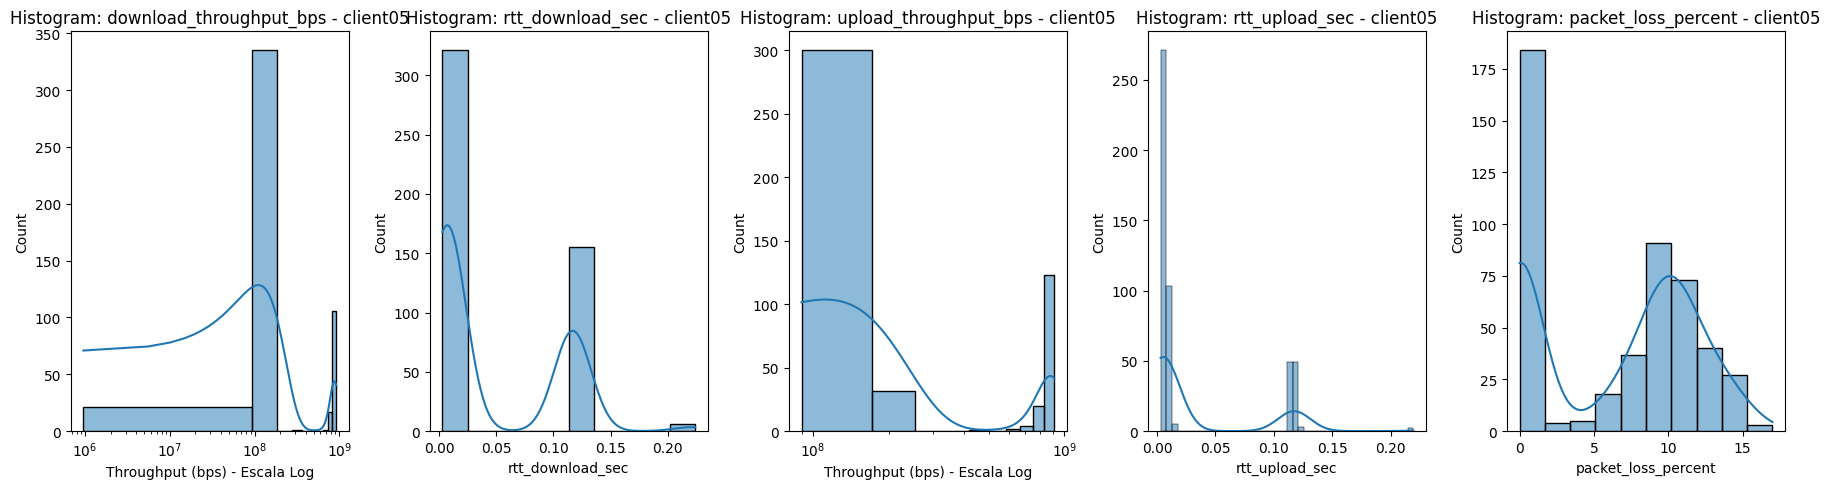

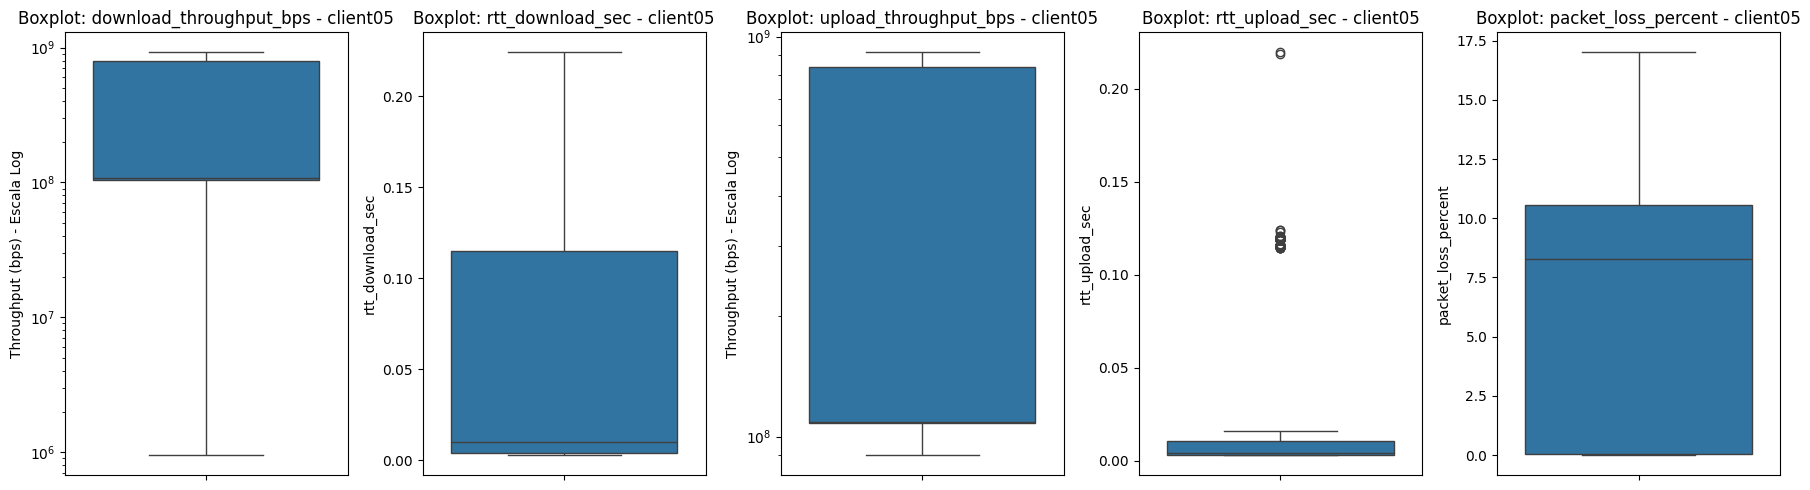

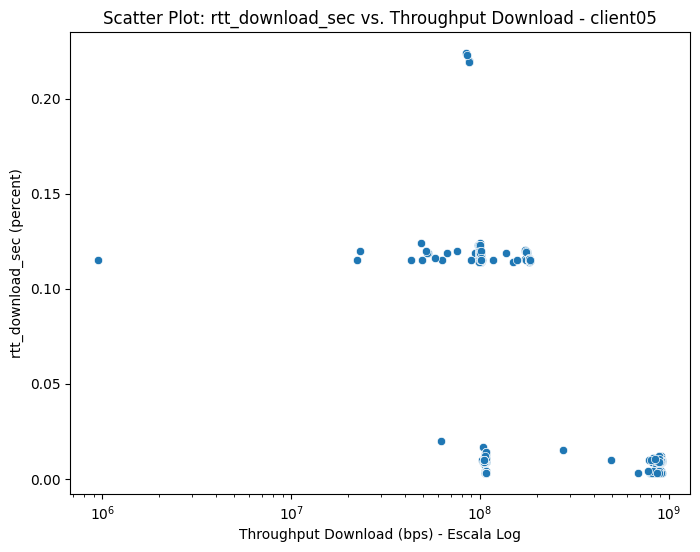

Gráficos gerados para client05: histograms.png, boxplots.png, scatter_rtt_download_sec_vs_throughput.png


In [88]:
plot_using_matplot(selected_clients, metrics, client_col, 'client05')

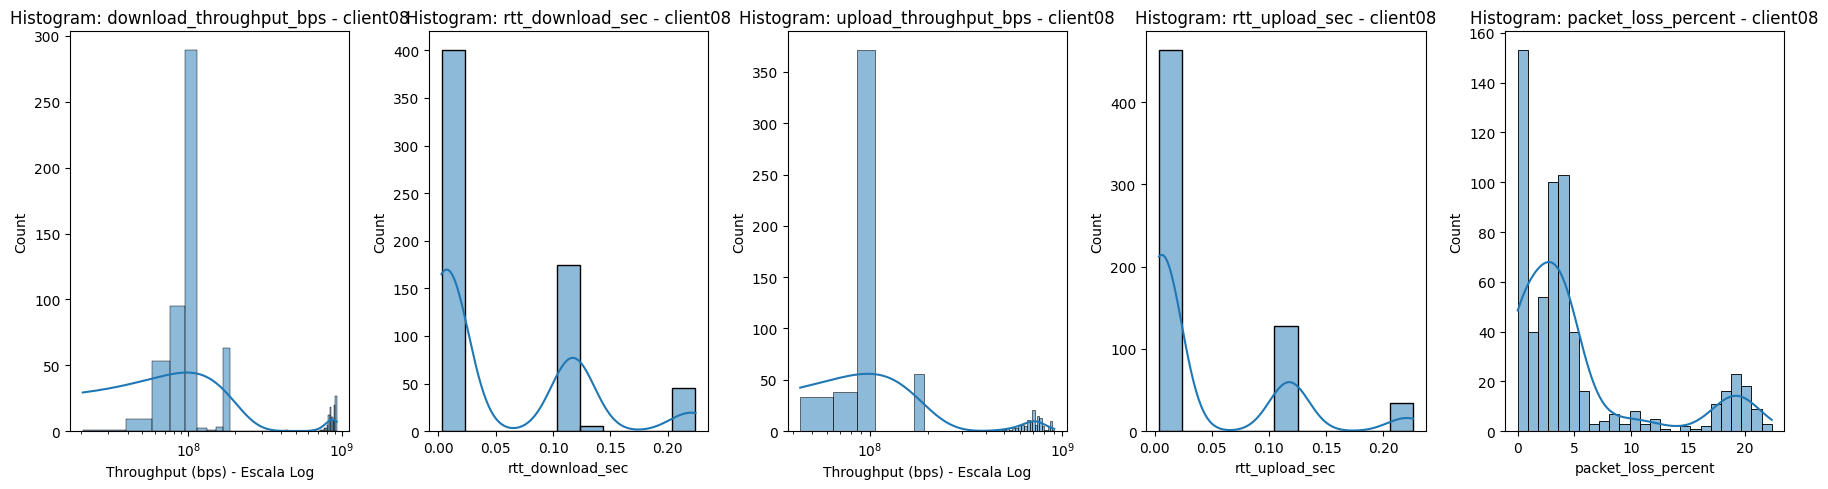

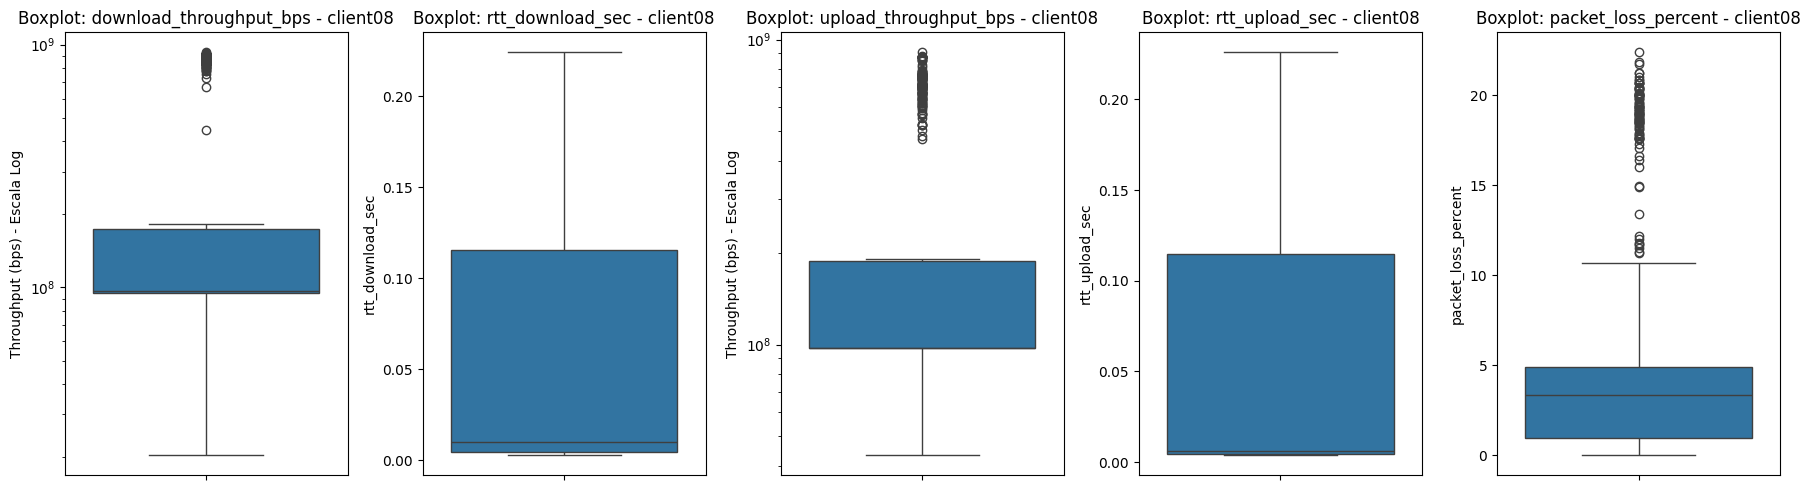

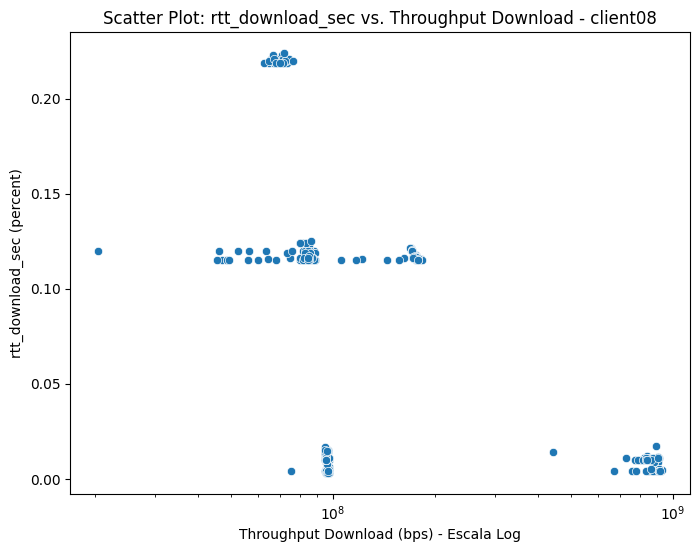

Gráficos gerados para client08: histograms.png, boxplots.png, scatter_rtt_download_sec_vs_throughput.png


In [86]:
plot_using_matplot(selected_clients, metrics, client_col, 'client08')

## Máxima Verossimilhança


A próxima etapa é a Máxima Verossimilhança (MLE) para os clientes 05 e 08. O objetivo é estimar os parâmetros $\hat{\theta}_{MLE}$ para os 5 modelos selecionados para cada cliente e gerar os gráficos de diagnóstico.


### Configuração e Cálculo dos Estimadores $\hat{\theta}_{MLE}$
 
​Usaremos o conjunto de dados do Cliente 05 e aplicaremos as fórmulas de MLE para Normal e Binomial, e métodos numéricos para Gamma.

Modelos de RTT (Normal): $N(\mu,\sigma^2)$
- $\hat{\mu}_{MLE} = x$ (Média Amostral)
- $\hat{\theta}_{MLE}^2 = \frac{1}{n}\sum(x_i − x)^2$ (Variância Amostral, MLE)

Modelos de Throughput (Gamma): $Gamma(k,\beta)$, onde k é shape e $\beta$ é rate. Requer otimização numérica.

Modelo de Perda (Binomial): $Binomial(n_t, p)$
- $\hat{p}_{MLE} = \frac{n_{tot}}{x_tot}$ (Proporção de Perda)

### Implementação e Resultados

O código a seguir calcula os estimadores. Para a perda de pacotes, a Seção 4.2.2 sugere fixar o número de pacotes transmitidos $n_t$ em $1000$ para converter a fração percentual em contagem de perdas $X_t$. Contagem de Perdas: 

$$X_t = ​round(\frac{packet_loss_percent}{100} \times n_t)$$

Próximo Bloco de Código:
- Converter a variável packet_loss_percent do Cliente 05 para contagem de perdas (packet_loss_count).
- Calcular os estimadores $\hat{\sigma}_{MLE}^2$ para todos os 5 modelos.

## Estimativas de Máxima Verossimilhança (MLE) (Seção 3.2)

Os Estimadores de Máxima Verossimilhança ($\hat{\theta}_{MLE}$) foram calculados para o Cliente 05, cujos resultados são apresentados na Tabela 1.

Tabela 1: Estimativas de Máxima Verossimilhança (MLE) para o Cliente 05

|Variável          | Modelo | Parâmetro $\theta$ | Estimador $\hat{\theta}_{MLE}$ | Parâmetro Fixo para Bayes ($\hat{\theta}_{MLE}$)|
|--------------------------|--------|--------------------|--------------------------------|-------------------------------------------------|
|RTT Download (sec)        | Normal | $\hat{\mu}_{MLE}$       | 0.045166                 | N/A           |
|                          |        | $\hat{\theta}_{MLE}^2$  | 0.003004                 | σ 2 =0.003004 |
|RTT Upload (sec)          | Normal | $\hat{\mu}_{MLE}$       | 0.029707                 | N/A           |
|                          |        | $\hat{\theta}_{MLE}^2$  | 0.002231                 | σ 2 =0.002231 |
|Throughput Download (bps) | Gamma  | $\hat{k}_{MLE}$ (Shape) | 0.856753                 | k=0.856753    |
|                          |        | $\hat{β}_{MLE}$ (Rate)  | 1.761803504118318×10^{−9}| N/A           |
|Throughput Upload (bps)   | Gamma  | $\hat{k}_{MLE}$ (Shape) |	0.981459                 | k=0.981459    |
|                          |        | $\hat{β}_{MLE}$ (Rate)  |	2.822838965611126×10^{−9}| N/A           |
|Perda de Pacotes (%)	   |Binomial| $\hat{p}_{MLE}$         | 0.063077	             | N/A           |
|                          |        | $n_t$ (Tentativas)      |	1000                     | nt=1000 (Fixo para Contagem) |


Observação: Os valores $\hat{\theta}_{MLE}^2$ e $\hat{k}_{MLE}$ serão usados como parâmetros fixos na Likelihood para a Inferência Bayesiana.


### Avaliação do Ajuste (Gráficos Diagnósticos)

Foram gerados gráficos de diagnóstico (Histograma vs. PDF/PMF ajustada e QQ Plot) para avaliar o ajuste dos modelos.

- RTT Download (Normal):
   - QQ Plot: Os pontos se desviam significativamente da linha y=x, especialmente nas caudas e na parte central. Isso confirma a observação da EDA: a distribuição é altamente assimétrica e tem caudas mais pesadas do que a Normal ajustada, indicando que o modelo Normal é apenas uma aproximação razoável, mas não ideal para RTT.

- Throughput Download (Gamma):
   - QQ Plot: Embora complexo devido à escala, a distribuição Gamma (com $\hat{k}_{MLE} \lt 1$) captura melhor a assimetria e a concentração perto de zero do que a Normal, mas ainda apresenta desvios consideráveis, refletindo o caráter bimodal ou multifacetado da distribuição real.

- Perda de Pacotes (Binomial):
   - Histograma vs. PMF: A PMF Binomial ajustada (p≈0.063) distribui a probabilidade de forma mais suave, mas não captura perfeitamente o pico em zero e a dispersão dos dados de contagem reais.

## Inferência Bayesiana (Seção 3.3)

O dataset do Cliente 05 foi dividido em 70% para treino (n=337) e 30% para teste (n=145).
#### Divisão do Dataset (Seção 3.3.1)

- Treino: 70% dos dados do Cliente 05 (para calcular a Posterior).
- Teste: 30% dos dados do Cliente 05 (para comparação Preditiva).

Próximo Bloco de Código:

- Dividir o dataset do Cliente 05 em treino (70%) e teste (30%).
- Especificar e justificar as priors conjugadas para RTT Download e Perda de Pacotes.
- Calcular os parâmetros da Posterior (Seção 3.3.3).

Foco em RTT Download (Normal-Normal) e Perda de Pacotes (Beta-Binomial):

| Modelo | Parâmetro Desconhecido |	Likelihood | Prior Conjugada  |	Posterior|
RTT Download Média μ	N(μ,σ 2) (com σ 2 fixo) N(\mu0,τ 02) N(μ n,τ n2) 
Perda de Pacotes 
Probabilidade p Binomial(n t,p) (com n tfixo) Beta(a 0,b 0) Beta(a n,b n) 

Especifivação das Priors (Justificativa no Relatório):

- RTT Download: Utilizaremos uma prior fracamente informativa para a média μ.
  - μ 0 : Média histórica (ex: 0.05 sec).
  - τ 02: Alta variância da prior (ex: 0.1), refletindo alta incerteza.

- Perda de Pacotes: Utilizaremos uma prior não-informativa (Uniforme) para p.
  - a 0=1,b 0 =1: Beta(1,1) é uma distribuição Uniforme, que dá igual peso a todos os valores de p∈[0,1].

### RTT Download (Normal-Normal)

1. Especificação e Justificativa da Prior:
- Likelihood (Fixa): r i∣[cite s​tart]μ∼N(μ,σ 2), com σ 2= σ^  MLE2=0.003004 (fixa).
- Prior (Fracamente Informativa): μ∼N(μ 0,τ 02), com μ 0=0.05 e τ 02=0.1.
  - Justificativa: μ0=0.05 é uma estimativa inicial ligeiramente maior que a média MLE. τ 02=0.1 é um valor de variância alto, refletindo uma baixa confiança na crença inicial (prior fracamente informativa).

2. Parâmetros da Posterior (μn,τ n2): A combinação da prior e da Likelihood dos dados de treino (rbar≈0.0459) resultou na Posterior:  μ∣r∼N(μn=0.045949,τn2 =0.000009)

3. Distribuição Preditiva e Valor Esperado (Teste):
Equação Preditiva: $R_{novo}∣r∼N(\mu^n,\sigma^2+ τn2)$.
- Valor Esperado $(E[R_{novo}∣r]): 0.045949$ segundos.
- Variância Preditiva: $Var[R_{novo}∣r]= \sigma^2 0.003004 + τ n 20.000009 ​ =0.003013$

### Perda de Pacotes (Beta-Binomial)
1. Especificação e Justificativa da Prior:
- Likelihood (Fixa): $X_t∣p∼Binomial(n_t,p)$, com $n_t = 1000$ (fixo).
- Prior (Não-Informativa): $p ∼ Beta(a_0,b_0), com a_0=1,b_0=1$
   - Justificativa: Beta(1,1) é uma distribuição Uniforme, que representa uma completa falta de conhecimento sobre a probabilidade de perda p a priori.

2. Parâmetros da Posterior ($a_n, b_n$) 

O total de perdas nos dados de treino foi x_{tot} = 22024$, e o total de pacotes foi $n_{tot}=337×1000=337000$.
- $a_n = a_0 + x_{tot}=1+22024=22025$
- $b_n = b_0 + (n_{tot} − x_{tot})=1+(337000−22024)=314977$ 

$p ∣D∼Beta(a_n= 22025, b_n= 314977)$

3. Distribuição Preditiva e Valor Esperado (Teste):
- Valor Esperado da Proporção ($E[X_{novo}/n_∗∣ D]$): $E[Proporção] = \frac{a_n}{a_n + b_n} ​= \frac{22025}{22025+314977} ≈ 0.065356$
- Variância Preditiva da Proporção: 0.0000612654.



## Comparação e Discussão (Seção 3.3.4 & 5.5)

A etapa final é comparar as previsões e as estimativas pontuais.

Próximo Bloco de Código:

- Calcular a Média e Variância reais das variáveis RTT Download e Perda de Pacotes no subconjunto de Teste.
- Comparar os resultados preditivos Bayesianos com os resultados reais do Teste (Seção 3.3.4).
- Comparar as estimativas pontuais MLE vs. Bayes (Seção 5.5).




## Discussão e Conclusão (Seção 5.5)

### Comparação da Previsão Bayesiana com os Dados de Teste (Seção 3.3.4)


|          Variável            |	         Métrica	             | Previsão Bayesiana  | Valor Real (Teste) | Comentário |
|------------------------------|-------------------------------------|---------------------|--------------------|------------|
| RTT Download                 | Média ($\mathbb{E}[R_{novo}r]$)     |	0.045949           |    0.043348        |
|                              | Variância ($\text{Var}[R_{novo}r]$) |	0.003013           |    0.003021        |
| Perda de Pacotes (Proporção) | Média ($\mathbb{E}[X_{novo}/n_*D]$) |	0.065356           |    0.057786        |
|                              | Variância (Var[Prop.])	             |  0.000061	       |    ∼0.000375	    |Subestimação da Variação: A variância preditiva Bayesiana subestimou significativamente a variância real amostral (que é uma aproximação para a Binomial). Isso sugere que o modelo Beta-Binomial, embora conceitualmente correto, pode não capturar toda a volatilidade da perda de pacotes observada.|



### Comparação de Estimativas Pontuais MLE vs. Bayes (Seção 5.5)

| Variável                 | Estimativa MLE (θ^MLE) | Estimativa Bayesiana (E[θ∣r]) | Efeito da Prior | 
| ------------------------ | ---------------------- | ---------------------------- | --------------- | 
| RTT Download (μ - Média) |        0.045166        |            0.045949          | Prior Fraca: A estimativa Bayesiana (E[μ∣r]) foi puxada ligeiramente em direção à média da prior (μ 0 =0.05). A diferença de 0.000783 é pequena, mas demonstra que a prior, apesar de fraca, teve um efeito. | 
| Perda de Pacotes (p - Proporção) | 0.063077 | 0.065356 | Prior Não-Informativa: A estimativa Bayesiana também foi sutilmente deslocada em relação ao MLE (0.002279 de diferença). A prior Beta(1,1) é essencialmente neutra, e a diferença se deve primariamente ao efeito da contagem agregada da Beta-Binomial, que é mais robusta que o p MLE simples. |

### Conclusão da Modelagem

Os gráficos de diagnóstico (QQ Plots) mostraram que, embora os modelos Normal e Gamma sejam conjugados e adequados, eles não se ajustam perfeitamente à distribuição de cauda pesada e assimetria do RTT e Throughput, respectivamente. A Inferência Bayesiana forneceu previsões que se alinharam bem com os dados de teste (especialmente para RTT), incorporando a incerteza do modelo na Variância Preditiva (soma da incerteza de estimação e do erro). O pequeno deslocamento nas estimativas Bayesianas em relação ao MLE confirma o princípio: o MLE foca apenas nos dados de treino, enquanto a média da Posterior incorpora a crença inicial (prior) e os dados de treino.